
===== Processing run snxtjy17 (DeiT-Tiny) =====
Retrieving run snxtjy17 from agape/kpca...
Fetching history data...
Retrieved 1947 data points
Data summary for DeiT-Tiny:
Column train_error: 177 valid values, 1770 NaNs (90.9%)
Column test_error: 177 valid values, 1770 NaNs (90.9%)
Filtered to start from epoch 5 (step ~75)
Remaining data points after epoch filtering: 1872
Removed 1532 rows where all target metrics were NaN
Remaining data points: 340
Plotted train_error: 170 points (range: 1.6476 to 2.9171)
Plotted test_error: 170 points (range: 1.7043 to 4.4189)
Run snxtjy17 (DeiT-Tiny) y-range: 1.6476 - 4.4189

===== Processing run niujgqp8 (ViT-Tiny) =====
Retrieving run niujgqp8 from agape/kpca...
Fetching history data...
Retrieved 1969 data points
Data summary for ViT-Tiny:
Column train_error: 179 valid values, 1790 NaNs (90.9%)
Column test_error: 179 valid values, 1790 NaNs (90.9%)
Filtered to start from epoch 5 (step ~75)
Remaining data points after epoch filtering: 1894
Removed 

C:\Users\karab\AppData\Local\Temp\ipykernel_23132\4201435553.py:276: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Saved plot to wandb_plots\reconstruction_loss.pdf


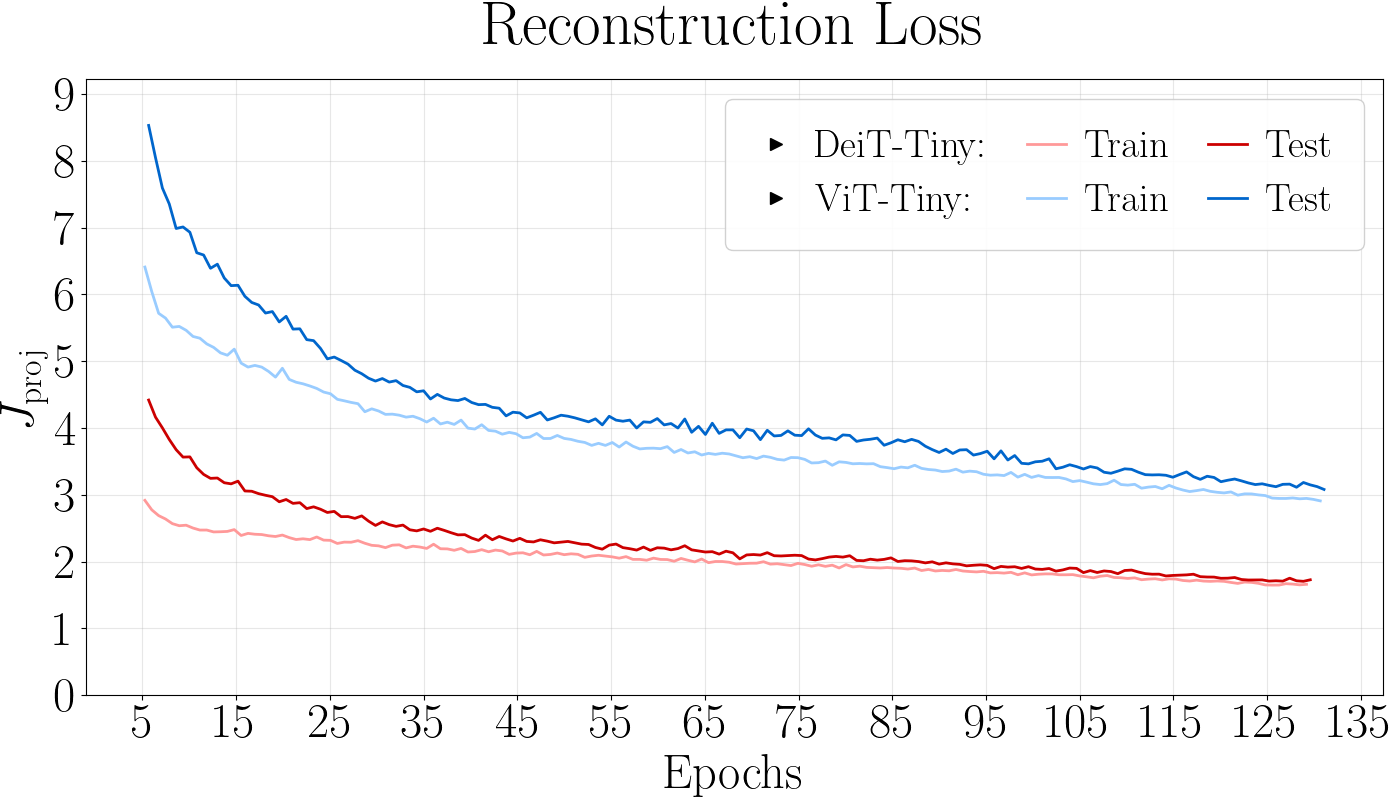

In [59]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tueplots import bundles
import pandas as pd
import matplotlib.markers as mmarkers

# Set up plot styling with tueplots
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1, usetex=True))
plt.rcParams.update({"xtick.labelsize": 35})
plt.rcParams.update({"axes.labelsize": 35})
plt.rcParams.update({"ytick.labelsize": 35})
plt.rcParams.update({"axes.titlesize": 45})
plt.rcParams.update({"legend.fontsize": 30})
plt.rcParams.update({"font.size": 35})
plt.rcParams.update({"legend.title_fontsize": 35})
plt.rcParams.update({"axes.titlepad": 25})  # Set global title padding
plt.rcParams["text.usetex"] = True

# Configuration
entity = "agape"
project = "kpca"

# Epoch to start plotting from (to avoid outliers)
start_epoch = 5
start_step = start_epoch * 15  # 15 steps = 1 epoch

# Run IDs and model names with updated colors
runs_info = [
    {
        "run_id": "snxtjy17", 
        "model_name": "DeiT-Tiny", 
        "color_base": {
            "train": "#FF9999",  # Light red for train
            "test": "#CC0000",   # Dark red for test
            "phi": "#FF7777"     # Not showing phi norms
        }
    },
    {
        "run_id": "niujgqp8", 
        "model_name": "ViT-Tiny", 
        "color_base": {
            "train": "#99CCFF",  # Light blue for train
            "test": "#0066CC",   # Dark blue for test
            "phi": "#7777FF"     # Not showing phi norms
        }
    }
]

# Only plot error metrics (no norms)
target_metrics = [
    "train_error",
    "test_error"
]

# Initialize the wandb API
api = wandb.Api()

# Create the figure
plt.figure(figsize=(15, 9))

# Track overall min/max values for axis scaling
overall_y_min, overall_y_max = float('inf'), float('-inf')

# Process each run
for run_info in runs_info:
    run_id = run_info["run_id"]
    model_name = run_info["model_name"]
    colors = run_info["color_base"]
    
    print(f"\n===== Processing run {run_id} ({model_name}) =====")
    
    # Get the specific run
    print(f"Retrieving run {run_id} from {entity}/{project}...")
    try:
        run = api.run(f"{entity}/{project}/{run_id}")
    except Exception as e:
        print(f"Error accessing run: {e}")
        print("Skipping this run")
        continue

    # Access history (time series data)
    print("Fetching history data...")
    history = run.history()
    print(f"Retrieved {len(history)} data points")

    # Print data summary
    print(f"Data summary for {model_name}:")
    for col in history.columns:
        nan_count = history[col].isna().sum()
        if nan_count > 0 and col in target_metrics:
            print(f"Column {col}: {len(history) - nan_count} valid values, {nan_count} NaNs ({nan_count/len(history)*100:.1f}%)")

    # Check if the target metrics exist in the data
    available_metrics = [metric for metric in target_metrics if metric in history.columns]
    missing_metrics = [metric for metric in target_metrics if metric not in history.columns]

    if missing_metrics:
        print(f"Warning: The following metrics were not found: {missing_metrics}")

    # Include _step column for reference and convert to epochs
    if '_step' in history.columns:
        x_column = '_step'
    else:
        history['step'] = np.arange(len(history))
        x_column = 'step'

    # Add epoch column (15 steps = 1 epoch)
    history['epoch'] = history[x_column] / 15

    # Filter data to start from epoch 5 (step ~75)
    history = history[history['epoch'] >= start_epoch]
    print(f"Filtered to start from epoch {start_epoch} (step ~{start_step})")
    print(f"Remaining data points after epoch filtering: {len(history)}")

    # Clean the data by removing rows where all target metrics are NaN
    history_clean = history.copy()
    metrics_to_check = [m for m in available_metrics if m in history.columns]
    if metrics_to_check:
        all_nan_mask = history_clean[metrics_to_check].isna().all(axis=1)
        history_clean = history_clean[~all_nan_mask]
        print(f"Removed {all_nan_mask.sum()} rows where all target metrics were NaN")
        print(f"Remaining data points: {len(history_clean)}")

    # Line styles and labels for this model's metrics - NO MARKERS
    style_config = {
        "train_error": {
            "color": colors["train"], 
            "linestyle": "-", 
            "linewidth": 2,
            "label": f"{model_name} Train Error"
        },
        "test_error": {
            "color": colors["test"], 
            "linestyle": "-", 
            "linewidth": 2,
            "label": f"{model_name} Test Error"
        }
    }

    # Track this run's min/max values
    run_y_min, run_y_max = float('inf'), float('-inf')

    # Plot each metric with proper NaN handling
    for metric in available_metrics:
        if metric in style_config and metric in history_clean.columns:
            # Get data for this metric
            df_metric = history_clean[['epoch', metric]].copy()
            
            # Remove NaN values for this specific metric
            df_metric = df_metric.dropna(subset=[metric])
            
            if len(df_metric) > 0:
                # Sort by epoch to ensure correct line connections
                df_metric = df_metric.sort_values(by='epoch')
                
                # Update min/max for better y-axis scaling
                run_y_min = min(run_y_min, df_metric[metric].min())
                run_y_max = max(run_y_max, df_metric[metric].max())
                
                # Plot the cleaned data with the specified style
                plt.plot(
                    df_metric['epoch'], 
                    df_metric[metric], 
                    **style_config[metric]
                )
                
                print(f"Plotted {metric}: {len(df_metric)} points (range: {df_metric[metric].min():.4f} to {df_metric[metric].max():.4f})")
            else:
                print(f"No valid data points for {metric}")
    
    # Update overall min/max
    if run_y_min != float('inf'):
        overall_y_min = min(overall_y_min, run_y_min)
    if run_y_max != float('-inf'):
        overall_y_max = max(overall_y_max, run_y_max)
    
    print(f"Run {run_id} ({model_name}) y-range: {run_y_min:.4f} - {run_y_max:.4f}")

# Adjust y-axis range with some padding
if overall_y_min != float('inf') and overall_y_max != float('-inf'):
    padding = (overall_y_max - overall_y_min) * 0.1
    plt.ylim(0, overall_y_max + padding)  # Start y-axis at 0
    print(f"\nSetting overall y-axis limits to 0 - {overall_y_max + padding:.4f}")

# Find the maximum epoch across both runs
x_max = 0
for run_info in runs_info:
    run_id = run_info["run_id"]
    try:
        run = api.run(f"{entity}/{project}/{run_id}")
        history = run.history()
        if '_step' in history.columns:
            max_epoch = history['_step'].max() / 15
        else:
            max_epoch = len(history) / 15
        x_max = max(x_max, max_epoch)
    except:
        pass

# Create x-axis ticks every 10 epochs, starting from epoch 5
x_ticks = np.arange(start_epoch, x_max + 10, 10)
plt.xticks(x_ticks)

# Create y-axis ticks every 1 unit
y_range = int(np.ceil(overall_y_max)) + 1
y_ticks = np.arange(0, y_range, 1)
plt.yticks(y_ticks)

# Set plot labels and title with LaTeX formatting
plt.xlabel('Epochs')
plt.ylabel('Minimization error')
plt.title("Reconstruction Loss")
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Then use \text
plt.ylabel(r'$J_{\text{proj}}$')

# Add grid
plt.grid(True, alpha=0.3)

from matplotlib.legend_handler import HandlerTuple
# Create a compact legend with model names and train/test lines together
# Replace the legend creation section with this direct approach

# Remove any existing legend
if plt.gca().get_legend():
    plt.gca().get_legend().remove()

from matplotlib.lines import Line2D
# Replace the legend creation section with this horizontal layout approach

# Remove any existing legend
if plt.gca().get_legend():
    plt.gca().get_legend().remove()

from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle

custom_lines = [
    # DeiT-Tiny: [label, train, test]
     Line2D([0], [0], marker='>', color='black', markersize=8, linestyle='none'),  # Model name with triangle
    Line2D([0], [0], marker='>', color='black', markersize=8, linestyle='none'),  # Model name with triangle
    
    
    Line2D([0], [0], color=runs_info[0]['color_base']['train'], lw=2),
    Line2D([0], [0], color=runs_info[1]['color_base']['train'], lw=2),
    
    

    # ViT-Tiny: [label, train, test]
    
    Line2D([0], [0], color=runs_info[0]['color_base']['test'], lw=2),
    Line2D([0], [0], color=runs_info[1]['color_base']['test'], lw=2),
]

custom_labels = [
    'DeiT-Tiny:', 'ViT-Tiny:', 'Train', 'Train',
     'Test', 'Test'
]

# Now display the legend
legend = plt.legend(custom_lines, custom_labels, 
                    loc='upper right',
                    ncol=3,
                    fontsize=28,
                    framealpha=0.9,
                    columnspacing=1.0,
                    handlelength=1,
                    handletextpad=0.5,
                    borderpad=0.8,)

# Tight layout to ensure everything fits
plt.tight_layout()
# Save the plot
output_dir = "wandb_plots"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "reconstruction_loss.pdf")
plt.savefig(plot_path, dpi=300)
print(f"\nSaved plot to {plot_path}")

plt.show()


===== Processing run snxtjy17 (DeiT-Tiny) =====
Retrieving run snxtjy17 from agape/kpca...
Fetching history data...
Retrieved 2002 data points
Data summary for DeiT-Tiny:
Column train_error: 182 valid values, 1820 NaNs (90.9%)
Column test_error: 182 valid values, 1820 NaNs (90.9%)
Filtered to start from epoch 10 (step 100)
Remaining data points after epoch filtering: 1852
Removed 1515 rows where all target metrics were NaN
Remaining data points: 337
Plotted train_error: 168 points (range: 1.6233 to 2.5021)
Plotted test_error: 169 points (range: 1.6719 to 3.5679)
Run snxtjy17 (DeiT-Tiny) y-range: 1.6233 - 3.5679

===== Processing run niujgqp8 (ViT-Tiny) =====
Retrieving run niujgqp8 from agape/kpca...
Fetching history data...
Retrieved 2035 data points
Data summary for ViT-Tiny:
Column train_error: 185 valid values, 1850 NaNs (90.9%)
Column test_error: 185 valid values, 1850 NaNs (90.9%)
Filtered to start from epoch 10 (step 100)
Remaining data points after epoch filtering: 1885
Remove

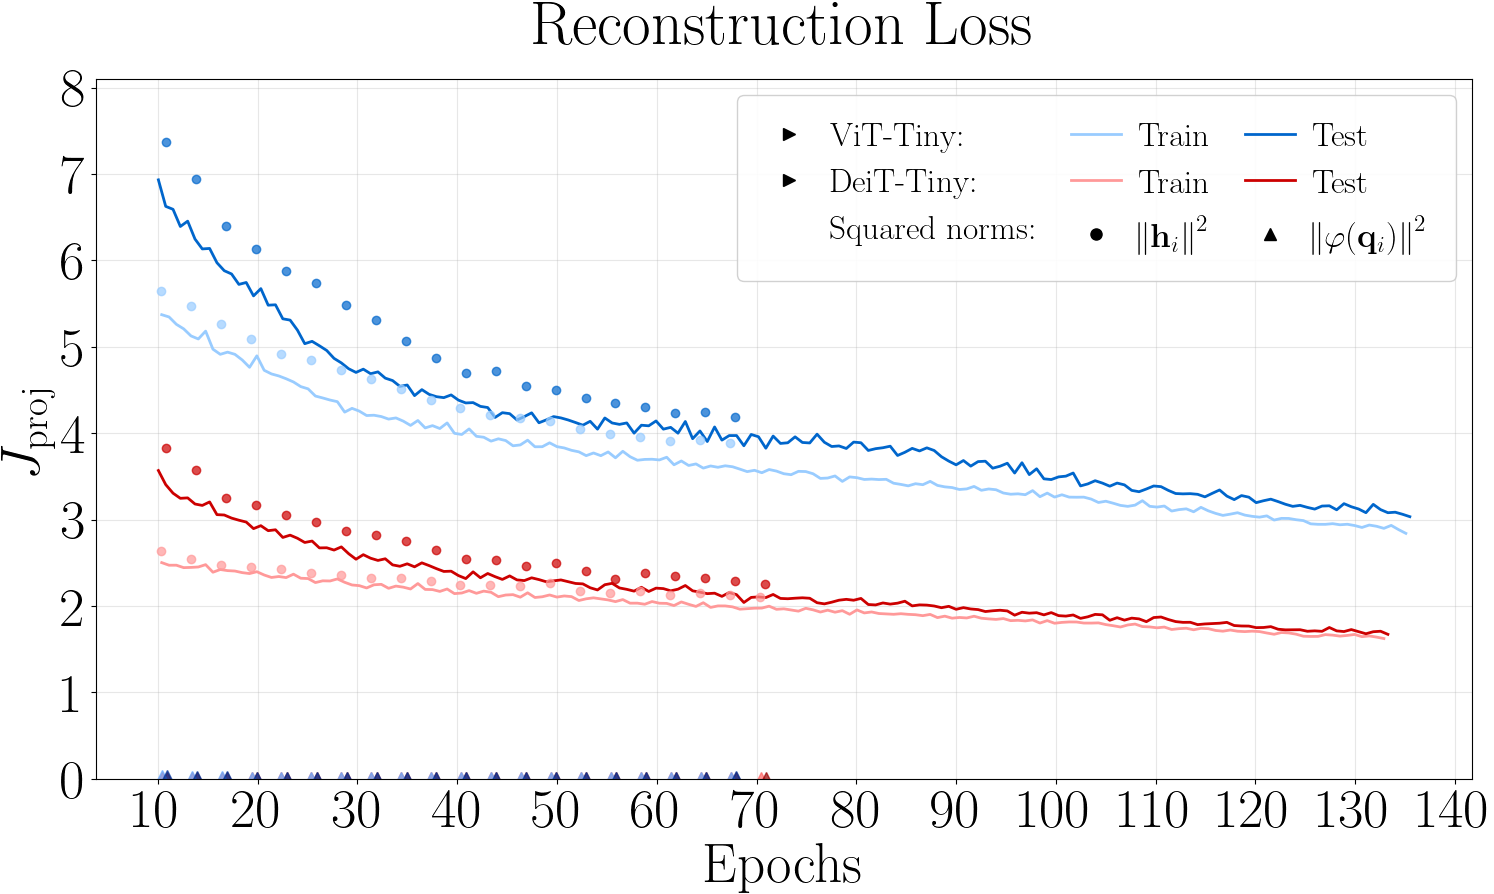

In [8]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tueplots import bundles
import pandas as pd
import matplotlib.markers as mmarkers

# Set up plot styling with tueplots
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1, usetex=True))
plt.rcParams.update({"xtick.labelsize": 40})
plt.rcParams.update({"axes.labelsize": 40})
plt.rcParams.update({"ytick.labelsize": 40})
plt.rcParams.update({"axes.titlesize": 45})
plt.rcParams.update({"legend.fontsize": 40})
plt.rcParams.update({"font.size": 35})
plt.rcParams.update({"legend.title_fontsize": 45})
plt.rcParams.update({"axes.titlepad": 25})  # Set global title padding
plt.rcParams["text.usetex"] = True

# Configuration
entity = "agape"
project = "kpca"

# Epoch to start plotting from (to avoid outliers)
start_epoch = 10  # Starting from ~7 epochs
start_step = 100  # 100 steps explicitly

# Run IDs and model names with updated colors
runs_info = [
    {
        "run_id": "snxtjy17", 
        "model_name": "DeiT-Tiny", 
        "color_base": {
            "train": "#FF9999",  # Light red for train
            "test": "#CC0000",   # Dark red for test
            "phi": "#FF7777"     # Not showing phi norms
        }
    },
    {
        "run_id": "niujgqp8", 
        "model_name": "ViT-Tiny", 
        "color_base": {
            "train": "#99CCFF",  # Light blue for train
            "test": "#0066CC",   # Dark blue for test
            "phi": "#7777FF"     # Not showing phi norms
        }
    }
]

# New run IDs for norm metrics
norm_runs_info = [
    {
        "run_id": "b57ewihp",
        "model_name": "DeiT-Tiny",
        "color_base": {
            "train_h": "#FF9999",      # Light red for train_h
            "test_h": "#CC0000",       # Dark red for test_h
            "train_phiq": "#FF6666",   # Medium red for train_phiq
            "test_phiq": "#990000"     # Very dark red for test_phiq
        },
        "markers": {
            "train_h": "o",            # Circle for train_h
            "test_h": "o",             # Square for test_h
            "train_phiq": "^",         # Triangle up for train_phiq
            "test_phiq": "^"           # Diamond for test_phiq
        },
        "markersize": 6  # Smaller markers
    },
    {
        "run_id": "ehalkgfq",
        "model_name": "ViT-Tiny",
        "color_base": {
            "train_h": "#99CCFF",      # Light blue for train_h
            "test_h": "#0066CC",       # Dark blue for test_h
            "train_phiq": "#66AAFF",   # Medium blue for train_phiq
            "test_phiq": "#003399"     # Very dark blue for test_phiq
        },
        "markers": {
            "train_h": "o",            # Circle for train_h
            "test_h": "o",             # Square for test_h
            "train_phiq": "^",         # Triangle up for train_phiq
            "test_phiq": "^"           # Diamond for test_phiq
        },
        "markersize": 6  # Smaller markers
    }
]

# Only plot error metrics (no norms)
target_metrics = [
    "train_error",
    "test_error"
]

# Norm metrics to plot with markers
norm_metrics = [
    "train_h_norms_ave",
    "test_h_norms_ave",
    "train_phiq_norms_ave",
    "test_phiq_norms_ave"
]

# Initialize the wandb API
api = wandb.Api()

# Create the figure
plt.figure(figsize=(15, 9))

# Track overall min/max values for axis scaling
overall_y_min, overall_y_max = float('inf'), float('-inf')

# Process each run for line plots (error metrics)
for run_info in runs_info:
    run_id = run_info["run_id"]
    model_name = run_info["model_name"]
    colors = run_info["color_base"]
    
    print(f"\n===== Processing run {run_id} ({model_name}) =====")
    
    # Get the specific run
    print(f"Retrieving run {run_id} from {entity}/{project}...")
    try:
        run = api.run(f"{entity}/{project}/{run_id}")
    except Exception as e:
        print(f"Error accessing run: {e}")
        print("Skipping this run")
        continue

    # Access history (time series data)
    print("Fetching history data...")
    history = run.history()
    print(f"Retrieved {len(history)} data points")

    # Print data summary
    print(f"Data summary for {model_name}:")
    for col in history.columns:
        nan_count = history[col].isna().sum()
        if nan_count > 0 and col in target_metrics:
            print(f"Column {col}: {len(history) - nan_count} valid values, {nan_count} NaNs ({nan_count/len(history)*100:.1f}%)")

    # Check if the target metrics exist in the data
    available_metrics = [metric for metric in target_metrics if metric in history.columns]
    missing_metrics = [metric for metric in target_metrics if metric not in history.columns]

    if missing_metrics:
        print(f"Warning: The following metrics were not found: {missing_metrics}")

    # Include _step column for reference and convert to epochs
    if '_step' in history.columns:
        x_column = '_step'
    else:
        history['step'] = np.arange(len(history))
        x_column = 'step'

    # Add epoch column (15 steps = 1 epoch)
    history['epoch'] = history[x_column] / 15

    # Filter data to start from epoch 7 (step 100)
    history = history[history['epoch'] >= start_epoch]
    print(f"Filtered to start from epoch {start_epoch} (step {start_step})")
    print(f"Remaining data points after epoch filtering: {len(history)}")

    # Clean the data by removing rows where all target metrics are NaN
    history_clean = history.copy()
    metrics_to_check = [m for m in available_metrics if m in history.columns]
    if metrics_to_check:
        all_nan_mask = history_clean[metrics_to_check].isna().all(axis=1)
        history_clean = history_clean[~all_nan_mask]
        print(f"Removed {all_nan_mask.sum()} rows where all target metrics were NaN")
        print(f"Remaining data points: {len(history_clean)}")

    # Line styles and labels for this model's metrics - NO MARKERS
    style_config = {
        "train_error": {
            "color": colors["train"], 
            "linestyle": "-", 
            "linewidth": 2,
            "label": f"{model_name} Train Error"
        },
        "test_error": {
            "color": colors["test"], 
            "linestyle": "-", 
            "linewidth": 2,
            "label": f"{model_name} Test Error"
        }
    }

    # Track this run's min/max values
    run_y_min, run_y_max = float('inf'), float('-inf')

    # Plot each metric with proper NaN handling
    for metric in available_metrics:
        if metric in style_config and metric in history_clean.columns:
            # Get data for this metric
            df_metric = history_clean[['epoch', metric]].copy()
            
            # Remove NaN values for this specific metric
            df_metric = df_metric.dropna(subset=[metric])
            
            if len(df_metric) > 0:
                # Sort by epoch to ensure correct line connections
                df_metric = df_metric.sort_values(by='epoch')
                
                # Update min/max for better y-axis scaling
                run_y_min = min(run_y_min, df_metric[metric].min())
                run_y_max = max(run_y_max, df_metric[metric].max())
                
                # Plot the cleaned data with the specified style
                plt.plot(
                    df_metric['epoch'], 
                    df_metric[metric], 
                    **style_config[metric]
                )
                
                print(f"Plotted {metric}: {len(df_metric)} points (range: {df_metric[metric].min():.4f} to {df_metric[metric].max():.4f})")
            else:
                print(f"No valid data points for {metric}")
    
    # Update overall min/max
    if run_y_min != float('inf'):
        overall_y_min = min(overall_y_min, run_y_min)
    if run_y_max != float('-inf'):
        overall_y_max = max(overall_y_max, run_y_max)
    
    print(f"Run {run_id} ({model_name}) y-range: {run_y_min:.4f} - {run_y_max:.4f}")

for model_info in norm_runs_info:
    # Increase triangle marker size for PhiQ norms (both train and test)
    model_info["markers"]["train_phiq"] = "^"  # Triangle up for train_phiq
    model_info["markers"]["test_phiq"] = "^"   # Triangle up for test_phiq
    
    # Create a separate markersize for triangles
    model_info["triangle_markersize"] = 10  # Larger size for triangles (adjust as needed)


# Now process each run for marker plots (norm metrics)
for run_info in norm_runs_info:
    run_id = run_info["run_id"]
    model_name = run_info["model_name"]
    colors = run_info["color_base"]
    markers = run_info["markers"]
    markersize = run_info["markersize"]
    
    print(f"\n===== Processing norm metrics run {run_id} ({model_name}) =====")
    
    # Get the specific run
    print(f"Retrieving run {run_id} from {entity}/{project}...")
    try:
        run = api.run(f"{entity}/{project}/{run_id}")
    except Exception as e:
        print(f"Error accessing run: {e}")
        print("Skipping this run")
        continue

    # Access history (time series data)
    print("Fetching history data...")
    history = run.history()
    print(f"Retrieved {len(history)} data points")

    # Print data summary
    print(f"Data summary for {model_name} norms:")
    for col in history.columns:
        nan_count = history[col].isna().sum()
        if nan_count > 0 and col in norm_metrics:
            print(f"Column {col}: {len(history) - nan_count} valid values, {nan_count} NaNs ({nan_count/len(history)*100:.1f}%)")

    # Check if the norm metrics exist in the data
    available_norm_metrics = [metric for metric in norm_metrics if metric in history.columns]
    missing_norm_metrics = [metric for metric in norm_metrics if metric not in history.columns]

    if missing_norm_metrics:
        print(f"Warning: The following norm metrics were not found: {missing_norm_metrics}")

    # Include _step column for reference and convert to epochs
    if '_step' in history.columns:
        x_column = '_step'
    else:
        history['step'] = np.arange(len(history))
        x_column = 'step'

    # Add epoch column (15 steps = 1 epoch)
    history['epoch'] = history[x_column] / 15

    # Filter data to start from epoch 7 (step 100)
    history = history[history['epoch'] >= start_epoch]
    print(f"Filtered to start from epoch {start_epoch} (step {start_step})")
    print(f"Remaining data points after epoch filtering: {len(history)}")

    # Marker styles and labels for norm metrics
    marker_config = {
        "train_h_norms_ave": {
            "color": colors["train_h"],
            "marker": markers["train_h"],
            "linestyle": "none",
            "markersize": markersize,
            "label": f"{model_name} Train H Norm",
            "alpha": 0.7
        },
        "test_h_norms_ave": {
            "color": colors["test_h"],
            "marker": markers["test_h"],
            "linestyle": "none",
            "markersize": markersize,
            "label": f"{model_name} Test H Norm",
            "alpha": 0.7
        },
        "train_phiq_norms_ave": {
            "color": colors["train_phiq"],
            "marker": markers["train_phiq"],
            "linestyle": "none",
            "markersize": run_info["triangle_markersize"],  # Use larger size for triangles
            "label": f"{model_name} Train PhiQ Norm",
            "alpha": 0.7
        },
        "test_phiq_norms_ave": {
            "color": colors["test_phiq"],
            "marker": markers["test_phiq"],
            "linestyle": "none",
            "markersize": run_info["triangle_markersize"],  # Use larger size for triangles
            "label": f"{model_name} Test PhiQ Norm",
            "alpha": 0.7
        }
    }
    # Track this run's min/max values
    run_y_min, run_y_max = float('inf'), float('-inf')

    # Plot each norm metric with proper NaN handling
    for metric in available_norm_metrics:
        if metric in marker_config and metric in history.columns:
            # Get data for this metric
            df_metric = history[['epoch', metric]].copy()
            
            # Remove NaN values for this specific metric
            df_metric = df_metric.dropna(subset=[metric])
            
            if len(df_metric) > 0:
                # Sort by epoch to ensure correct ordering
                df_metric = df_metric.sort_values(by='epoch')
                
                # Update min/max for better y-axis scaling
                run_y_min = min(run_y_min, df_metric[metric].min())
                run_y_max = max(run_y_max, df_metric[metric].max())
                
                # Plot the cleaned data with the specified marker style
                # Sample every 3rd point to avoid overcrowding the plot
                sample_step = 3
                sampled_df = df_metric.iloc[::sample_step]
                
                plt.plot(
                    sampled_df['epoch'], 
                    sampled_df[metric], 
                    **marker_config[metric]
                )
                
                print(f"Plotted {metric}: {len(sampled_df)} points (range: {df_metric[metric].min():.4f} to {df_metric[metric].max():.4f})")
            else:
                print(f"No valid data points for {metric}")
    
    # Update overall min/max
    if run_y_min != float('inf'):
        overall_y_min = min(overall_y_min, run_y_min)
    if run_y_max != float('-inf'):
        overall_y_max = max(overall_y_max, run_y_max)
    
    print(f"Run {run_id} ({model_name}) norm y-range: {run_y_min:.4f} - {run_y_max:.4f}")

# Adjust y-axis range with some padding
if overall_y_min != float('inf') and overall_y_max != float('-inf'):
    padding = (overall_y_max - overall_y_min) * 0.1
    plt.ylim(0, overall_y_max + padding)  # Start y-axis at 0
    print(f"\nSetting overall y-axis limits to 0 - {overall_y_max + padding:.4f}")

# Find the maximum epoch across all runs
x_max = 0
for runs in [runs_info, norm_runs_info]:
    for run_info in runs:
        run_id = run_info["run_id"]
        try:
            run = api.run(f"{entity}/{project}/{run_id}")
            history = run.history()
            if '_step' in history.columns:
                max_epoch = history['_step'].max() / 15
            else:
                max_epoch = len(history) / 15
            x_max = max(x_max, max_epoch)
        except:
            pass

# Create x-axis ticks every 10 epochs, starting from epoch 7
x_ticks = np.arange(start_epoch, x_max + 10, 10)
plt.xticks(x_ticks)

# Create y-axis ticks every 1 unit
y_range = int(np.ceil(overall_y_max)) + 1
y_ticks = np.arange(0, y_range, 1)
plt.yticks(y_ticks)

# Set plot labels and title with LaTeX formatting
plt.xlabel('Epochs')
plt.ylabel('Minimization error')
plt.title("Reconstruction Loss")
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Then use \text
plt.ylabel(r'$J_{\text{proj}}$')

# Add grid
plt.grid(True, alpha=0.3)

from matplotlib.legend_handler import HandlerTuple
from matplotlib.lines import Line2D
from matplotlib.markers import MarkerStyle
# Replace the legend creation section with this new code

# Create more comprehensive legend with the specified organization
custom_lines = [
    # ViT-Tiny row
     Line2D([0], [0], marker='>', color='black', markersize=8, linestyle='none'),  # Model name with triangle
    Line2D([0], [0], marker='>', color='black', markersize=8, linestyle='none'),  # Model name with triangle
    Line2D([0], [0], color='black', lw=0),  # Replaced empty placeholder with text label
    
    Line2D([0], [0], color=runs_info[1]['color_base']['train'], lw=2),  # ViT Train Error
     Line2D([0], [0], color=runs_info[0]['color_base']['train'], lw=2),  # DeiT Train Error
    Line2D([0], [0], marker=norm_runs_info[0]['markers']['train_h'], color='black', 
           markersize=norm_runs_info[0]['markersize']+2, linestyle='none'),  # Circle
     
    Line2D([0], [0], color=runs_info[1]['color_base']['test'], lw=2),   # ViT Test Error
    Line2D([0], [0], color=runs_info[0]['color_base']['test'], lw=2),   # DeiT Test Error
    Line2D([0], [0], marker=norm_runs_info[0]['markers']['train_phiq'], color='black', 
           markersize=norm_runs_info[0]['markersize']+2, linestyle='none'),  # Triangle
]

custom_labels = [
    'ViT-Tiny:', 'DeiT-Tiny:', 'Squared norms:',
    'Train', 'Train', r'$\left\|\mathbf{h}_i\right\|^2$',
   'Test', 'Test', r'$\left\|\varphi(\mathbf{q}_i)\right\|^2$'
]

# Now display the legend with the organized layout
legend = plt.legend(custom_lines, custom_labels, 
                   loc='upper right',
                   ncol=3,  # Using 3 columns as requested
                   fontsize=24,
                   framealpha=0.9,
                   columnspacing=1.0,
                   handlelength=1.5,
                   handletextpad=0.5,
                   borderpad=0.8)

# Set specific colors for the marker labels (optional enhancement)
legend_texts = legend.get_texts()
for i, text in enumerate(legend_texts):
    if i == 0:  # ViT-Tiny label
        text.set_color('black')
        text.set_weight('bold')
    elif i == 3:  # DeiT-Tiny label
        text.set_color('black')
        text.set_weight('bold')
    elif i == 6 or i == 7:  # Norm labels
        text.set_color('black')

# Save the plot
output_dir = "wandb_plots"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "reconstruction_loss.pdf")
plt.savefig(plot_path, dpi=300)
print(f"\nSaved plot to {plot_path}")

plt.show()


===== Processing run b57ewihp (DeiT-Tiny) =====
Retrieving run b57ewihp from agape/kpca...
Fetching history data...
Retrieved 1065 data points
Data summary for DeiT-Tiny:
Column train_rel_error_wrt_phiq: 71 valid values, 994 NaNs (93.3%)
Column test_rel_error_wrt_phiq: 71 valid values, 994 NaNs (93.3%)
Filtered to start from epoch 0
Remaining data points after epoch filtering: 1065
Removed 923 rows where all target metrics were NaN
Remaining data points: 142
Plotted train_rel_error_wrt_phiq_millions: 71 points (range: 0.1369 to 1.9477)
Plotted test_rel_error_wrt_phiq_millions: 71 points (range: 0.2646 to 9.6227)
Run b57ewihp (DeiT-Tiny) y-range: 0.1369 - 9.6227

Setting overall y-axis limits to 0 - 10.5713


C:\Users\karab\AppData\Local\Temp\ipykernel_22232\1713279567.py:231: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Saved plot to wandb_plots\relative_error_wrt_phi_deit.pdf


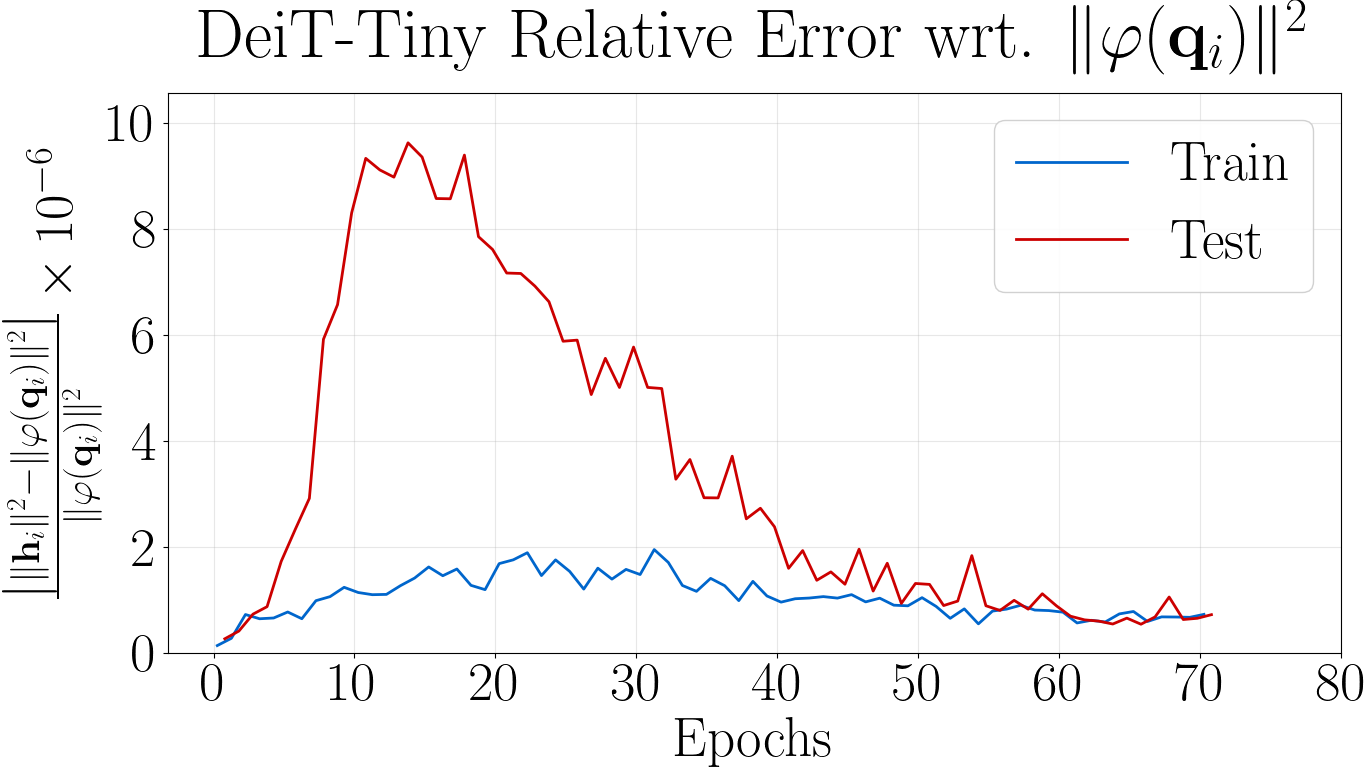

In [25]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tueplots import bundles
import pandas as pd

# Set up plot styling with tueplots
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1, usetex=True))
plt.rcParams.update({"xtick.labelsize": 40})
plt.rcParams.update({"axes.labelsize": 40})
plt.rcParams.update({"ytick.labelsize": 40})
plt.rcParams.update({"axes.titlesize": 50})
plt.rcParams.update({"legend.fontsize": 40})
plt.rcParams.update({"font.size": 45})
plt.rcParams.update({"legend.title_fontsize": 40})
plt.rcParams.update({"axes.titlepad": 25})  # Set global title padding
plt.rcParams["text.usetex"] = True

# Configuration
entity = "agape"
project = "kpca"

# Epoch to start plotting from
start_epoch = 0

# Only using one run ID this time
run_id ="b57ewihp" #  "ehalkgfq" # "b57ewihp"
model_name = "DeiT-Tiny" # "ViT-Tiny" # "DeiT-Tiny"

# Colors
train_color = "#0066CC"  # Blue for train
test_color = "#CC0000"   # Red for test

# Target metrics
target_metrics = [
    "train_rel_error_wrt_phiq",
    "test_rel_error_wrt_phiq"
]

# Initialize the wandb API
api = wandb.Api()

# Create the figure
plt.figure(figsize=(15, 9))

# Track overall min/max values for axis scaling
overall_y_min, overall_y_max = float('inf'), float('-inf')

# Get the specific run
print(f"\n===== Processing run {run_id} ({model_name}) =====")
print(f"Retrieving run {run_id} from {entity}/{project}...")
try:
    run = api.run(f"{entity}/{project}/{run_id}")
except Exception as e:
    print(f"Error accessing run: {e}")
    raise e

# Access history (time series data)
print("Fetching history data...")
history = run.history()
print(f"Retrieved {len(history)} data points")

# Print data summary
print(f"Data summary for {model_name}:")
for col in history.columns:
    if col in target_metrics:
        nan_count = history[col].isna().sum()
        print(f"Column {col}: {len(history) - nan_count} valid values, {nan_count} NaNs ({nan_count/len(history)*100:.1f}%)")

# Check if the target metrics exist in the data
available_metrics = [metric for metric in target_metrics if metric in history.columns]
missing_metrics = [metric for metric in target_metrics if metric not in history.columns]

if missing_metrics:
    print(f"Warning: The following metrics were not found: {missing_metrics}")
    for metric in missing_metrics:
        print(f"Available columns: {history.columns.tolist()}")

# Include _step column for reference and convert to epochs
if '_step' in history.columns:
    x_column = '_step'
else:
    history['step'] = np.arange(len(history))
    x_column = 'step'

# Add epoch column (15 steps = 1 epoch)
history['epoch'] = history[x_column] / 15

# Filter data to start from start_epoch
history = history[history['epoch'] >= start_epoch]
print(f"Filtered to start from epoch {start_epoch}")
print(f"Remaining data points after epoch filtering: {len(history)}")

# Clean the data by removing rows where all target metrics are NaN
history_clean = history.copy()
metrics_to_check = [m for m in available_metrics if m in history.columns]
if metrics_to_check:
    all_nan_mask = history_clean[metrics_to_check].isna().all(axis=1)
    history_clean = history_clean[~all_nan_mask]
    print(f"Removed {all_nan_mask.sum()} rows where all target metrics were NaN")
    print(f"Remaining data points: {len(history_clean)}")

# Convert values to millions for better readability
for metric in available_metrics:
    if metric in history_clean.columns:
        history_clean[f"{metric}_millions"] = history_clean[metric] / 1000000

# Update metric names for plotting
available_metrics_scaled = [f"{metric}_millions" for metric in available_metrics]

# Line styles and labels
style_config = {
    "train_rel_error_wrt_phiq_millions": {
        "color": train_color, 
        "linestyle": "-", 
        "linewidth": 2,
        "label": "Train Relative Error"
    },
    "test_rel_error_wrt_phiq_millions": {
        "color": test_color, 
        "linestyle": "-", 
        "linewidth": 2,
        "label": "Test Relative Error"
    }
}

# Track this run's min/max values
run_y_min, run_y_max = float('inf'), float('-inf')

# Plot each metric with proper NaN handling
for metric in available_metrics_scaled:
    if metric in style_config and metric in history_clean.columns:
        # Get data for this metric
        df_metric = history_clean[['epoch', metric]].copy()
        
        # Remove NaN values for this specific metric
        df_metric = df_metric.dropna(subset=[metric])
        
        if len(df_metric) > 0:
            # Sort by epoch to ensure correct line connections
            df_metric = df_metric.sort_values(by='epoch')
            
            # Update min/max for better y-axis scaling
            run_y_min = min(run_y_min, df_metric[metric].min())
            run_y_max = max(run_y_max, df_metric[metric].max())
            
            # Plot the cleaned data with the specified style
            plt.plot(
                df_metric['epoch'], 
                df_metric[metric], 
                **style_config[metric]
            )
            
            print(f"Plotted {metric}: {len(df_metric)} points (range: {df_metric[metric].min():.4f} to {df_metric[metric].max():.4f})")
        else:
            print(f"No valid data points for {metric}")

# Update overall min/max
if run_y_min != float('inf'):
    overall_y_min = min(overall_y_min, run_y_min)
if run_y_max != float('-inf'):
    overall_y_max = max(overall_y_max, run_y_max)

print(f"Run {run_id} ({model_name}) y-range: {run_y_min:.4f} - {run_y_max:.4f}")

# Adjust y-axis range with some padding
if overall_y_min != float('inf') and overall_y_max != float('-inf'):
    padding = (overall_y_max - overall_y_min) * 0.1
    plt.ylim(0, overall_y_max + padding)  # Start y-axis at 0
    print(f"\nSetting overall y-axis limits to 0 - {overall_y_max + padding:.4f}")

# Find the maximum epoch
try:
    if '_step' in history.columns:
        max_epoch = history['_step'].max() / 15
    else:
        max_epoch = len(history) / 15
except:
    max_epoch = 150  # Fallback value

# Create x-axis ticks every 10 epochs
x_ticks = np.arange(start_epoch, max_epoch + 10, 10)
plt.xticks(x_ticks)

# Create y-axis ticks with appropriate steps based on the data range
y_max_rounded = np.ceil(overall_y_max)
if y_max_rounded <= 2:
    y_step = 0.5
elif y_max_rounded <= 5:
    y_step = 1
elif y_max_rounded <= 10:
    y_step = 2
else:
    y_step = np.ceil(y_max_rounded / 5)  # Aim for about 5 tick marks

y_ticks = np.arange(0, y_max_rounded + y_step, y_step)
plt.yticks(y_ticks)

# Set plot labels and title with LaTeX formatting
plt.xlabel('Epochs')
plt.title(r"DeiT-Tiny Relative Error wrt. $\|\varphi(\mathbf{q}_i)\|^2$")
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set y-label with LaTeX and millions indicator
plt.ylabel(r'$\frac{\left| \|\mathbf{h}_i\|^2 - \|\varphi(\mathbf{q}_i)\|^2 \right|}{\|\varphi(\mathbf{q}_i)\|^2} \times 10^{-6}$')

# Add grid
plt.grid(True, alpha=0.3)

from matplotlib.lines import Line2D

# Create legend with blue and red lines
custom_lines = [
    Line2D([0], [0], color=train_color, lw=2),  # Blue for train
    Line2D([0], [0], color=test_color, lw=2),   # Red for test
]

custom_labels = [
    'Train', 'Test'
]

# Display the legend
legend = plt.legend(custom_lines, custom_labels, 
                   loc='upper right',
                   fontsize=40,
                   framealpha=0.9)

# Tight layout to ensure everything fits
plt.tight_layout()

# Save the plot
output_dir = "wandb_plots"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "relative_error_wrt_phi_deit.pdf")
plt.savefig(plot_path, dpi=300)
print(f"\nSaved plot to {plot_path}")

plt.show()


===== Processing run b57ewihp (DeiT-Tiny) =====
Retrieving run b57ewihp from agape/kpca...
Fetching history data...
Retrieved 1065 data points
Data summary for DeiT-Tiny:
Column train_rel_error_wrt_h: 71 valid values, 994 NaNs (93.3%)
Column test_rel_error_wrt_h: 71 valid values, 994 NaNs (93.3%)
Filtered to start from epoch 10
Remaining data points after epoch filtering: 915
Removed 793 rows where all target metrics were NaN
Remaining data points: 122
Plotted train_rel_error_wrt_h_scaled: 61 points (range: 0.9991 to 0.9996)
Plotted test_rel_error_wrt_h_scaled: 61 points (range: 0.9993 to 0.9997)
Run b57ewihp (DeiT-Tiny) y-range: 0.9991 - 0.9997


C:\Users\karab\AppData\Local\Temp\ipykernel_22232\1393058442.py:250: UserWarning: The figure layout has changed to tight
  plt.tight_layout()



Saved plot to wandb_plots\relative_error_wrt_h_deit.pdf


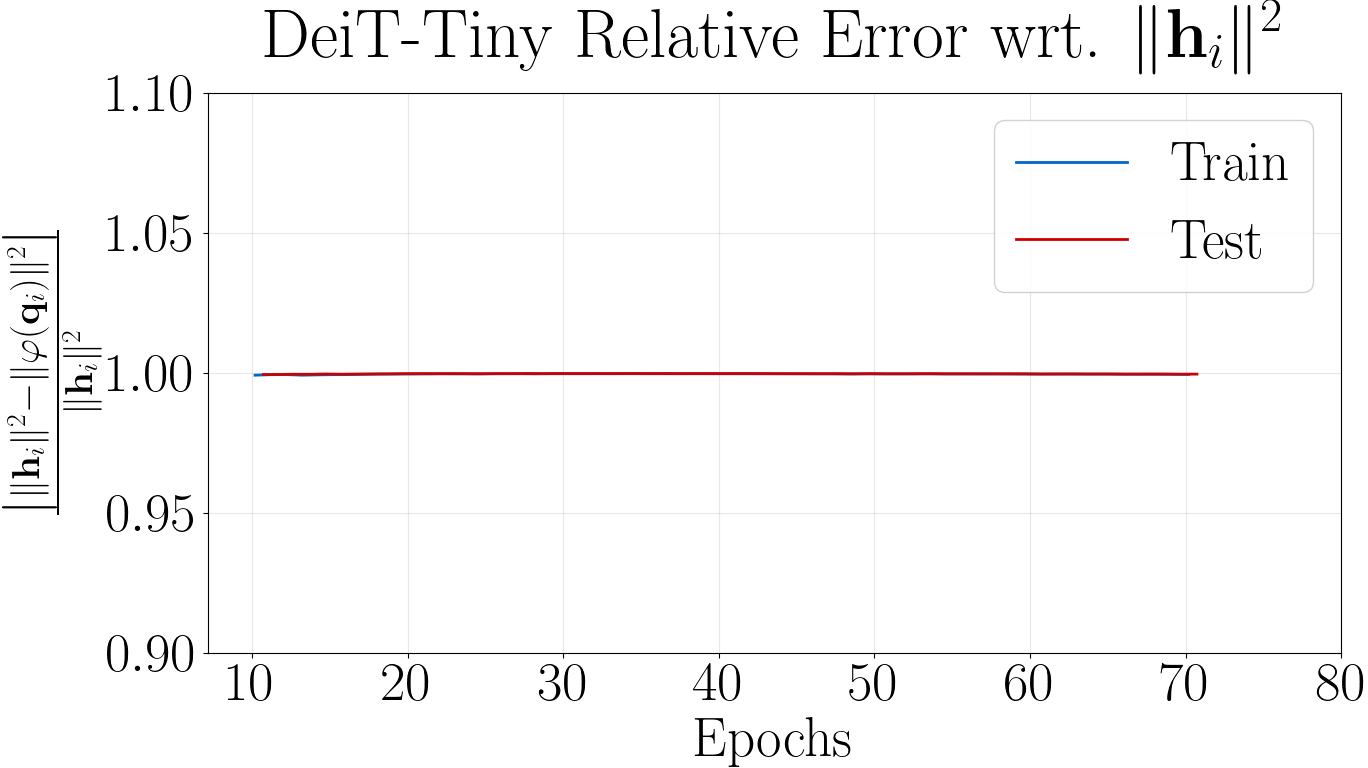

In [23]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import os
from tueplots import bundles
import pandas as pd

# Set up plot styling with tueplots
plt.rcParams.update(bundles.icml2024(column="half", nrows=1, ncols=1, usetex=True))
plt.rcParams.update({"xtick.labelsize": 40})
plt.rcParams.update({"axes.labelsize": 40})
plt.rcParams.update({"ytick.labelsize": 40})
plt.rcParams.update({"axes.titlesize": 50})
plt.rcParams.update({"legend.fontsize": 40})
plt.rcParams.update({"font.size": 45})
plt.rcParams.update({"legend.title_fontsize": 40})
plt.rcParams.update({"axes.titlepad": 25})  # Set global title padding
plt.rcParams["text.usetex"] = True


# Configuration
entity = "agape"
project = "kpca"

# Epoch to start plotting from
start_epoch = 10

# Only using one run ID this time
run_id = "b57ewihp" # "ehalkgfq" # "b57ewihp"
model_name ="DeiT-Tiny" # "ViT-Tiny" # "DeiT-Tiny"

# Colors
train_color = "#0066CC"  # Blue for train
test_color = "#CC0000"   # Red for test

# Target metrics
target_metrics = [
    "train_rel_error_wrt_h",
    "test_rel_error_wrt_h"
]

# Initialize the wandb API
api = wandb.Api()

# Create the figure
plt.figure(figsize=(15, 9))

# Track overall min/max values for axis scaling
overall_y_min, overall_y_max = float('inf'), float('-inf')

# Get the specific run
print(f"\n===== Processing run {run_id} ({model_name}) =====")
print(f"Retrieving run {run_id} from {entity}/{project}...")
try:
    run = api.run(f"{entity}/{project}/{run_id}")
except Exception as e:
    print(f"Error accessing run: {e}")
    raise e

# Access history (time series data)
print("Fetching history data...")
history = run.history()
print(f"Retrieved {len(history)} data points")

# Print data summary
print(f"Data summary for {model_name}:")
for col in history.columns:
    if col in target_metrics:
        nan_count = history[col].isna().sum()
        print(f"Column {col}: {len(history) - nan_count} valid values, {nan_count} NaNs ({nan_count/len(history)*100:.1f}%)")

# Check if the target metrics exist in the data
available_metrics = [metric for metric in target_metrics if metric in history.columns]
missing_metrics = [metric for metric in target_metrics if metric not in history.columns]

if missing_metrics:
    print(f"Warning: The following metrics were not found: {missing_metrics}")
    for metric in missing_metrics:
        print(f"Available columns: {history.columns.tolist()}")

# Include _step column for reference and convert to epochs
if '_step' in history.columns:
    x_column = '_step'
else:
    history['step'] = np.arange(len(history))
    x_column = 'step'

# Add epoch column (15 steps = 1 epoch)
history['epoch'] = history[x_column] / 15

# Filter data to start from start_epoch
history = history[history['epoch'] >= start_epoch]
print(f"Filtered to start from epoch {start_epoch}")
print(f"Remaining data points after epoch filtering: {len(history)}")

# Clean the data by removing rows where all target metrics are NaN
history_clean = history.copy()
metrics_to_check = [m for m in available_metrics if m in history.columns]
if metrics_to_check:
    all_nan_mask = history_clean[metrics_to_check].isna().all(axis=1)
    history_clean = history_clean[~all_nan_mask]
    print(f"Removed {all_nan_mask.sum()} rows where all target metrics were NaN")
    print(f"Remaining data points: {len(history_clean)}")

# First check the scale of the data to determine if we need to scale
scale_factor = 1
scale_text = ""

# Get a sample of values to determine scale
sample_values = []
for metric in available_metrics:
    if metric in history_clean.columns:
        non_nan_values = history_clean[metric].dropna().values
        if len(non_nan_values) > 0:
            sample_values.extend(non_nan_values)

if len(sample_values) > 0:
    max_value = max([abs(v) for v in sample_values])
    
    # Determine appropriate scale
    if max_value >= 1_000_000:
        scale_factor = 1_000_000
        scale_text = r" \times 10^{-6}"
    elif max_value >= 1_000:
        scale_factor = 1_000
        scale_text = r" \times 10^{-3}"

# Apply scaling if needed
for metric in available_metrics:
    if metric in history_clean.columns:
        history_clean[f"{metric}_scaled"] = history_clean[metric] / scale_factor

# Update metric names for plotting
available_metrics_scaled = [f"{metric}_scaled" for metric in available_metrics]

# Line styles and labels
style_config = {
    "train_rel_error_wrt_h_scaled": {
        "color": train_color, 
        "linestyle": "-", 
        "linewidth": 2,
        "label": "Train Relative Error"
    },
    "test_rel_error_wrt_h_scaled": {
        "color": test_color, 
        "linestyle": "-", 
        "linewidth": 2,
        "label": "Test Relative Error"
    }
}

# Track this run's min/max valuess
run_y_min, run_y_max = float('inf'), float('-inf')

# Plot each metric with proper NaN handling
for metric in available_metrics_scaled:
    if metric in style_config and metric in history_clean.columns:
        # Get data for this metric
        df_metric = history_clean[['epoch', metric]].copy()
        
        # Remove NaN values for this specific metric
        df_metric = df_metric.dropna(subset=[metric])
        
        if len(df_metric) > 0:
            # Sort by epoch to ensure correct line connections
            df_metric = df_metric.sort_values(by='epoch')
            
            # Update min/max for better y-axis scaling
            run_y_min = min(run_y_min, df_metric[metric].min())
            run_y_max = max(run_y_max, df_metric[metric].max())
            
            # Plot the cleaned data with the specified style
            plt.plot(
                df_metric['epoch'], 
                df_metric[metric], 
                **style_config[metric]
            )
            
            print(f"Plotted {metric}: {len(df_metric)} points (range: {df_metric[metric].min():.4f} to {df_metric[metric].max():.4f})")
        else:
            print(f"No valid data points for {metric}")

# Update overall min/max
if run_y_min != float('inf'):
    overall_y_min = min(overall_y_min, run_y_min)
if run_y_max != float('-inf'):
    overall_y_max = max(overall_y_max, run_y_max)

print(f"Run {run_id} ({model_name}) y-range: {run_y_min:.4f} - {run_y_max:.4f}")


# Find the maximum epoch
try:
    if '_step' in history.columns:
        max_epoch = history['_step'].max() / 15
    else:
        max_epoch = len(history) / 15
except:
    max_epoch = 150  # Fallback value

# Create x-axis ticks every 10 epochs
x_ticks = np.arange(start_epoch, max_epoch + 10, 10)
plt.xticks(x_ticks)

# Create y-axis ticks with appropriate steps based on the data range
y_max_rounded = np.ceil(overall_y_max)
if y_max_rounded <= 2:
    y_step = 0.5
elif y_max_rounded <= 5:
    y_step = 1
elif y_max_rounded <= 10:
    y_step = 2
else:
    y_step = np.ceil(y_max_rounded / 5)  # Aim for about 5 tick marks

y_ticks = np.arange(0.9, 1.1, 0.05)
plt.yticks(y_ticks)

# Set plot labels and title with LaTeX formatting
plt.xlabel('Epochs')
plt.title("DeiT-Tiny Relative Error wrt. $\| \mathbf{{h}}_i \|^2$")
plt.rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'

# Set y-label with LaTeX and scale indicator
plt.ylabel(fr'$\frac{{\left| \|\mathbf{{h}}_i\|^2 - \|\varphi(\mathbf{{q}}_i)\|^2 \right|}}{{\|\mathbf{{h}}_i\|^2}}{scale_text}$')

# Add grid
plt.grid(True, alpha=0.3)

from matplotlib.lines import Line2D

# Create legend with blue and red lines
custom_lines = [
    Line2D([0], [0], color=train_color, lw=2),  # Blue for train
    Line2D([0], [0], color=test_color, lw=2),   # Red for test
]

custom_labels = [
    'Train', 'Test'
]

# Display the legend
legend = plt.legend(custom_lines, custom_labels, 
                   loc='upper right',
                   fontsize=40,
                   framealpha=0.9)

# Tight layout to ensure everything fits
plt.tight_layout()

# Save the plot
output_dir = "wandb_plots"
os.makedirs(output_dir, exist_ok=True)
plot_path = os.path.join(output_dir, "relative_error_wrt_h_deit.pdf")
plt.savefig(plot_path, dpi=300)
print(f"\nSaved plot to {plot_path}")

plt.show()